In [1]:
import os
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models
from loss import custom_loss

from loss import *
from models import *
from dataloaders import utils
from dataloaders import OptimizedDataGenerator as DG

pi = 3.14159265359

maxval=1e9
minval=1e-9

2024-12-03 04:39:17.630640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 04:39:17.630707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 04:39:17.632357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 04:39:17.640028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 04:39:21.480777: W tensorflow/compiler/tf2

In [2]:
def load_sensor_geometries(file_path):
    sensor_geometries = {}
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line and not line.startswith("#"):  # Skip comments and empty lines
                dataset_type, geometry = line.split(": ")
                sensor_geometries[dataset_type.strip()] = geometry.strip()
    return sensor_geometries
sensor_geometries = load_sensor_geometries('types.txt')

In [3]:
dataset_name = 'dataset2s'

types = ['type7', 'type7', 'type6', 'type6']
time_sl = [2, 20, 2, 20]
fingerprints = ['74b96477', 'd1d9581a', '6c18c396', 'c8fe3c7d']
for type in types:
    print(sensor_geometries[f'{dataset_name} {type}'])

100 um x 25 um x 150 um sensor @ 175V
100 um x 25 um x 150 um sensor @ 175V
100 um x 25 um x 100 um sensor @ 100V
100 um x 25 um x 100 um sensor @ 100V


In [4]:
for i, type in enumerate(types): 
    print(f'{types[i]}:',{sensor_geometries[f'{dataset_name} {type}']})


type7: {'100 um x 25 um x 150 um sensor @ 175V'}
type7: {'100 um x 25 um x 150 um sensor @ 175V'}
type6: {'100 um x 25 um x 100 um sensor @ 100V'}
type6: {'100 um x 25 um x 100 um sensor @ 100V'}


In [5]:
models = []
for i in range(len(types)):
    model = CreateModel((13,21,time_sl[i]), n_filters=5, pool_size=3)
    model.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
        loss=custom_loss
    )
    models.append(model)

    base_dir = f'./trained_models_{time_sl[i]}t/{types[i]}/model-{fingerprints[i]}-checkpoints'
    checkpoint_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.hdf5')]
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    training_cp_path = os.path.join(base_dir, 'training_log.csv')
    training_history = pd.read_csv(training_cp_path)

    print(f"Loading model from {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
del model

2024-12-03 04:39:33.739501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 854 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 7g.40gb, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-12-03 04:39:33.895528: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Loading model from ./trained_models_2t/type7/model-74b96477-checkpoints/weights.78-t-19575.89-v-20709.42.hdf5
Loading model from ./trained_models_20t/type7/model-d1d9581a-checkpoints/weights.91-t-23324.42-v-25057.09.hdf5
Loading model from ./trained_models_2t/type6/model-6c18c396-checkpoints/weights.97-t-20860.26-v-21503.66.hdf5
Loading model from ./trained_models_20t/type6/model-c8fe3c7d-checkpoints/weights.87-t-24319.67-v-25442.14.hdf5


In [6]:
test_generators = []
p_tests = []
df_s = []
resX = []
resY = []
resA = []
resB  = []

for i in range(len(types)):
    tfrecords_dir_val = f'/depot/cms/users/das214/{dataset_name}/{types[i]}/unflipped/TFR_{time_sl[i]}t_val'
    print(tfrecords_dir_val)
    test_generator = DG.OptimizedDataGenerator(
        load_from_tfrecords_dir = tfrecords_dir_val,
        quantize = True
    )
    test_generators.append(test_generator)
    p_test = models[i].predict(test_generator)
    p_tests.append(p_test)

    complete_truth = None
    for _, y in tqdm(test_generator):
            if complete_truth is None:
                complete_truth = y
            else:
                complete_truth = np.concatenate((complete_truth, y), axis=0)

    df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])
    
    # stores all true values in same matrix as xtrue, ytrue, etc.
    df['xtrue'] = complete_truth[:,0]
    df['ytrue'] = complete_truth[:,1]
    df['cotAtrue'] = complete_truth[:,2]
    df['cotBtrue'] = complete_truth[:,3]
    df['M11'] = minval+tf.math.maximum(df['M11'], 0)
    df['M22'] = minval+tf.math.maximum(df['M22'], 0)
    df['M33'] = minval+tf.math.maximum(df['M33'], 0)
    df['M44'] = minval+tf.math.maximum(df['M44'], 0)
    
    df['sigmax'] = abs(df['M11'])
    df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
    df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
    df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)
    
    # calculates residuals for x, y, cotA, cotB
    residuals = df['xtrue'] - df['x']
    residualsy = df['ytrue'] - df['y']
    residualsA = df['cotAtrue'] - df['cotA']
    residualsB = df['cotBtrue'] - df['cotB']

    df_s.append(df)
    resX.append(residuals)
    resY.append(residualsy)
    resA.append(residualsA)
    resB.append(residualsB)




/depot/cms/users/das214/dataset2s/type7/unflipped/TFR_2t_val


 2/58 [>.............................] - ETA: 9s 

2024-12-03 04:39:38.674211: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


58/58 [==============================] - 10s 173ms/step


100%|██████████| 58/58 [00:03<00:00, 14.87it/s]


/depot/cms/users/das214/dataset2s/type7/unflipped/TFR_20t_val


58/58 [==============================] - 32s 548ms/step


100%|██████████| 58/58 [00:09<00:00,  6.04it/s]


/depot/cms/users/das214/dataset2s/type6/unflipped/TFR_2t_val


58/58 [==============================] - 11s 189ms/step


100%|██████████| 58/58 [00:03<00:00, 15.05it/s]


/depot/cms/users/das214/dataset2s/type6/unflipped/TFR_20t_val


58/58 [==============================] - 39s 668ms/step


100%|██████████| 58/58 [00:09<00:00,  6.02it/s]


# residuals (mean, stdv)

In [7]:
# x
(np.mean(residuals)*75,np.std(residuals)*75)

(0.4497801885008812, 8.877849206328392)

In [8]:
# y
(np.mean(residualsy)*18.75,np.std(residualsy)*18.75)

(-0.16635870561003685, 1.8058434594422579)

In [9]:
# cotA
(np.mean(residualsA)*8,np.std(residualsA)*8)

(-0.034075092524290085, 0.33352839946746826)

In [10]:
# cotB
(np.mean(residualsB)*0.5,np.std(residualsB)*0.5)

(-0.00375710753723979, 0.0642964094877243)

# x residuals

type 0: {'100 um x 25 um x 150 um sensor @ 175V'}
type 1: {'100 um x 25 um x 150 um sensor @ 175V'}
type 2: {'100 um x 25 um x 100 um sensor @ 100V'}
type 3: {'100 um x 25 um x 100 um sensor @ 100V'}


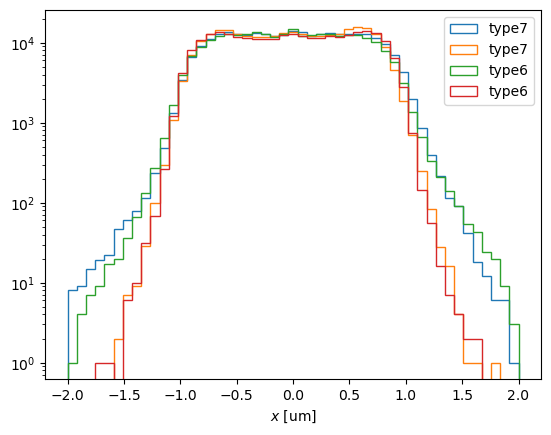

In [11]:
bins = np.linspace(-2, 2, 50)
for i, type in enumerate(types): 
    print(f'type {i}:',{sensor_geometries[f'{dataset_name} {type}']})
    plt.hist(p_tests[i][:,0],bins=bins, histtype='step', label = type)
plt.yscale('log')
plt.xlabel(r'$x$ [um]')
plt.legend()
save_fig_path = os.path.join(base_dir, 'x_dist.png')
plt.savefig(save_fig_path)

plt.show()

type 0: {'100 um x 25 um x 150 um sensor @ 175V'}
type 1: {'100 um x 25 um x 150 um sensor @ 175V'}
type 2: {'100 um x 25 um x 100 um sensor @ 100V'}
type 3: {'100 um x 25 um x 100 um sensor @ 100V'}


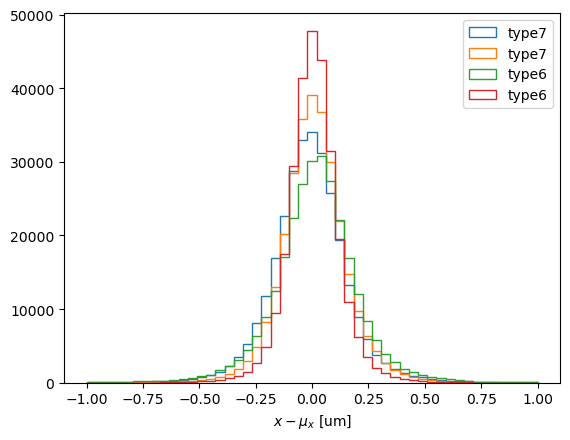

In [12]:
bins=np.linspace(-1,1,50)
for i, type in enumerate(types): 
    print(f'type {i}:',{sensor_geometries[f'{dataset_name} {type}']})
    plt.hist(resX[i],bins=bins, histtype='step', label = type)
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.legend()
save_fig_path = os.path.join(base_dir, 'x_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

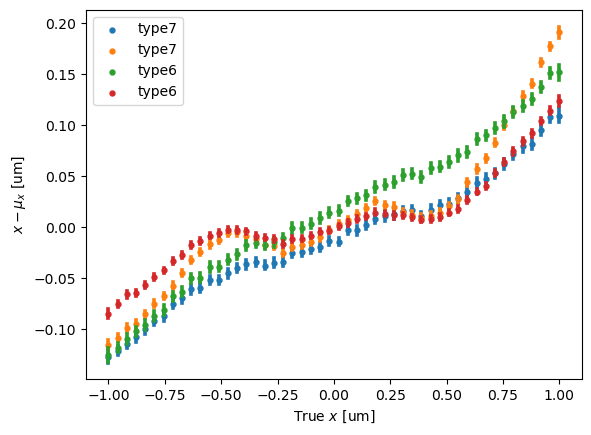

In [13]:
for i, type in enumerate(types): 
    x = sns.regplot(x=df_s[i]['xtrue'], y=(df_s[i]['xtrue']-df_s[i]['x']),
                    x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.', label = type)
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')
plt.legend()
save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# y residuals

type 0: {'100 um x 25 um x 150 um sensor @ 175V'}
type 1: {'100 um x 25 um x 150 um sensor @ 175V'}
type 2: {'100 um x 25 um x 100 um sensor @ 100V'}
type 3: {'100 um x 25 um x 100 um sensor @ 100V'}


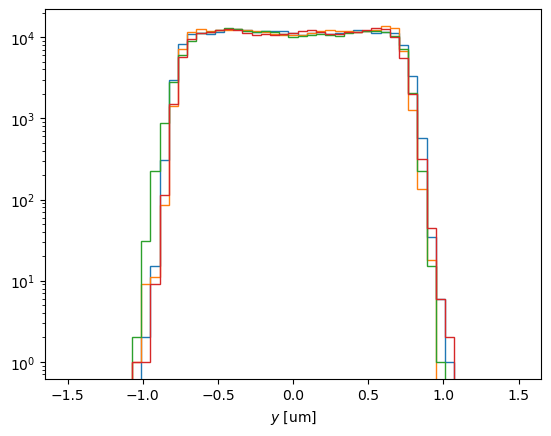

In [14]:
bins=np.linspace(-1.5,1.5,50)
for i, type in enumerate(types): 
    print(f'type {i}:',{sensor_geometries[f'{dataset_name} {type}']})
    plt.hist(p_tests[i][:,2],bins=bins, histtype='step', label = type)

plt.yscale('log')
plt.xlabel(r'$y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_dist.png')
plt.savefig(save_fig_path)

plt.show()

type 0: {'100 um x 25 um x 150 um sensor @ 175V'}
type 1: {'100 um x 25 um x 150 um sensor @ 175V'}
type 2: {'100 um x 25 um x 100 um sensor @ 100V'}
type 3: {'100 um x 25 um x 100 um sensor @ 100V'}


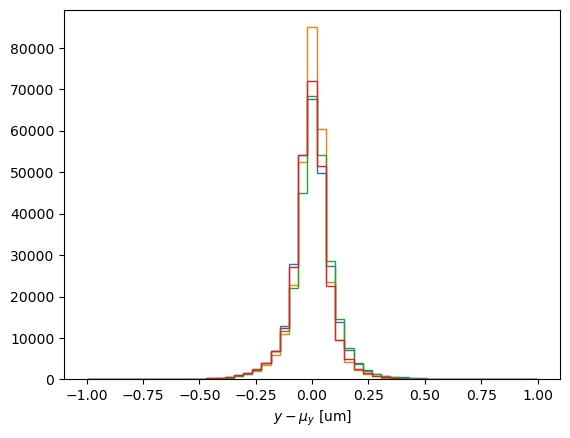

In [15]:
bins=np.linspace(-1,1,50)
for i, type in enumerate(types): 
    print(f'type {i}:',{sensor_geometries[f'{dataset_name} {type}']})
    plt.hist(resY[i],bins=bins, histtype='step', label = type)

#plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

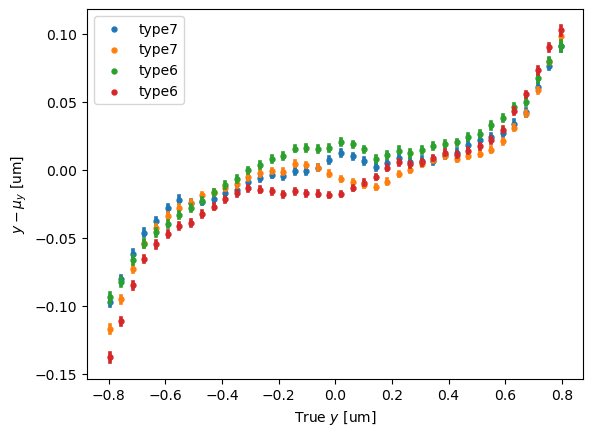

In [16]:
for i, type in enumerate(types): 
    x = sns.regplot(x=df_s[i]['ytrue'], y=(df_s[i]['ytrue']-df_s[i]['y']), x_bins=np.linspace(-1,1,50),
                    fit_reg=None, marker='.', label = type)
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')
plt.legend()

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotA residuals

type 0: {'100 um x 25 um x 150 um sensor @ 175V'}
type 1: {'100 um x 25 um x 150 um sensor @ 175V'}
type 2: {'100 um x 25 um x 100 um sensor @ 100V'}
type 3: {'100 um x 25 um x 100 um sensor @ 100V'}


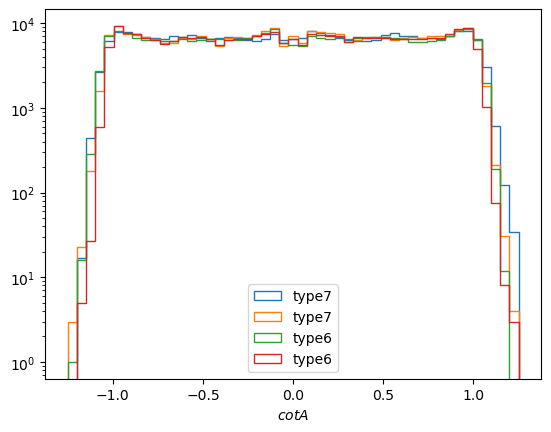

In [17]:
bins=np.linspace(-1.25,1.25,50)
for i, type in enumerate(types): 
    print(f'type {i}:',{sensor_geometries[f'{dataset_name} {type}']})
    plt.hist(p_tests[i][:,4],bins=bins, histtype='step', label = type)

plt.yscale('log')
plt.xlabel(r'$cotA$')
plt.legend()

save_fig_path = os.path.join(base_dir, 'cotA_dist.png')
plt.savefig(save_fig_path)

plt.show()

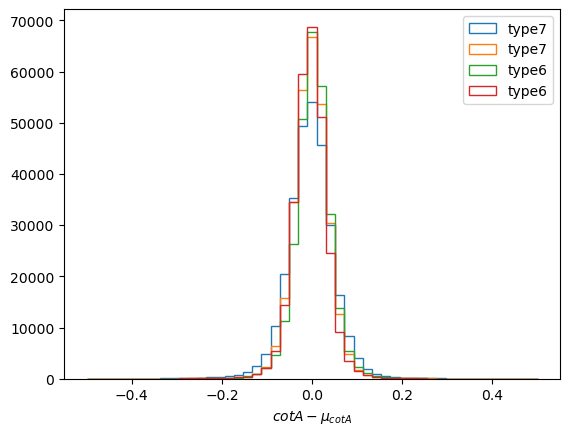

In [18]:
bins=np.linspace(-0.5,0.5,50)
for i, type in enumerate(types): 
    plt.hist(resA[i],bins=bins, histtype='step', label = type)
#plt.yscale('Log')
plt.xlabel(r'$cotA-\mu_{cotA}$')
plt.legend()

save_fig_path = os.path.join(base_dir, 'cotA_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

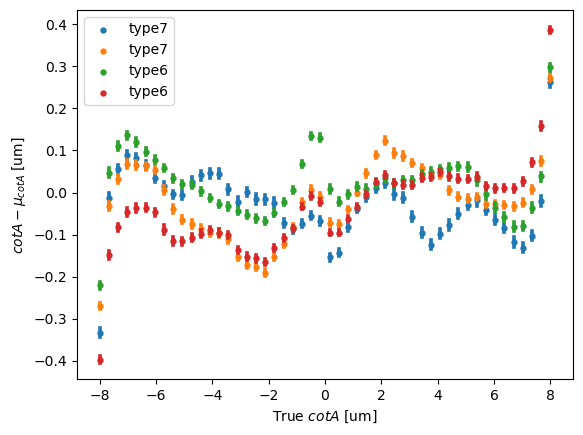

In [19]:

for i, type in enumerate(types): 
    x = sns.regplot(x=df_s[i]['cotAtrue']*8, y=(df_s[i]['cotAtrue']-df_s[i]['cotA'])*8,
                    x_bins=np.linspace(-8,8,50), fit_reg=None, marker='.', label = type)
plt.xlabel(r'True $cotA$ [um]')
plt.ylabel(r'$cotA-\mu_{cotA}$ [um]')
plt.legend()

save_fig_path = os.path.join(base_dir, 'cotA_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotB residuals

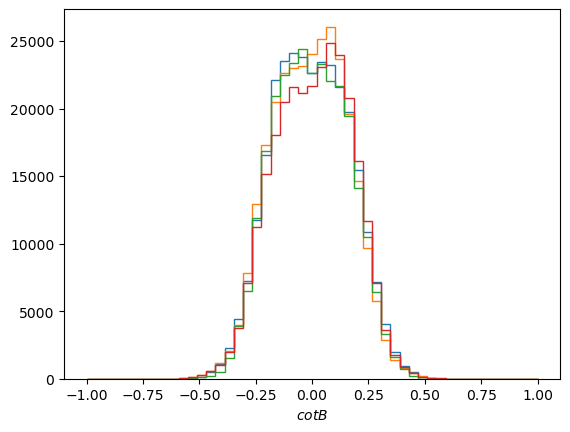

In [20]:
bins=np.linspace(-1,1,50)
for i, type in enumerate(types): 
    plt.hist(p_tests[i][:,6]*0.5,bins=bins, histtype='step', label = type)
#plt.yscale('Log')
plt.xlabel(r'$cotB$')

save_fig_path = os.path.join(base_dir, 'cotB_dist.png')
plt.savefig(save_fig_path)

plt.show()

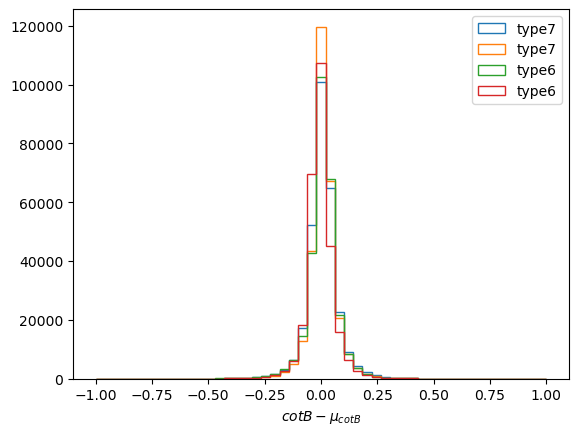

In [21]:
bins=np.linspace(-1,1,50)
for i, type in enumerate(types): 
     plt.hist(resB[i]*0.5,bins=bins, histtype='step', label = type)
    
#plt.yscale('Log')
#plt.yscale('Log')
plt.xlabel(r'$cotB-\mu_{cotB}$')
plt.legend()

save_fig_path = os.path.join(base_dir, 'cotB_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

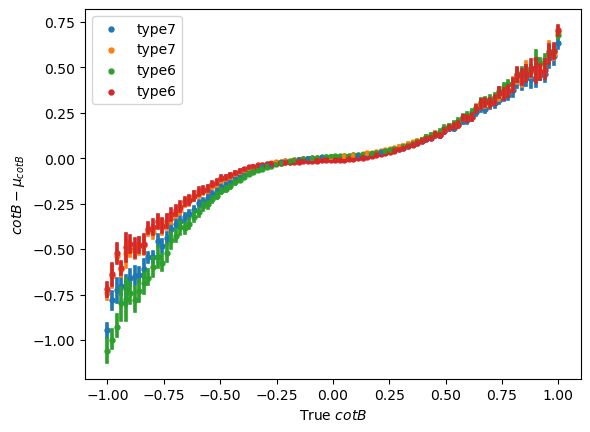

In [22]:
for i, type in enumerate(types): 
    x = sns.regplot(x=df_s[i]['cotBtrue']*0.5, y=(df_s[i]['cotBtrue']-df_s[i]['cotB'])*0.5,
                    x_bins=np.linspace(-1,1,100), fit_reg=None, marker='.', label = type)
plt.xlabel(r'True $cotB$')
plt.ylabel(r'$cotB-\mu_{cotB} $')
plt.legend()

save_fig_path = os.path.join(base_dir, 'cotB_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# pull

In [23]:
for i, type in enumerate(types): 
    df_s[i]['pullx'] = (df_s[i]['xtrue']-df_s[i]['x'])/df_s[i]['sigmax']
    df_s[i]['pully'] = (df_s[i]['ytrue']-df_s[i]['y'])/df_s[i]['sigmay']
    df_s[i]['pullcotA'] = (df_s[i]['cotAtrue']-df_s[i]['cotA'])/df_s[i]['sigmacotA']
    df_s[i]['pullcotB'] = (df_s[i]['cotBtrue']-df_s[i]['cotB'])/df_s[i]['sigmacotB']

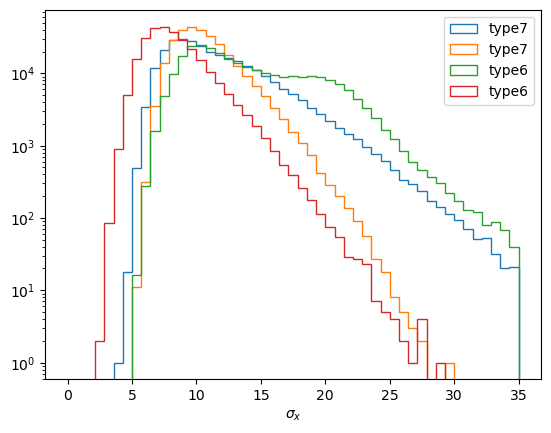

In [24]:
for i, type in enumerate(types): 
    plt.hist(df_s[i]['sigmax'] * 75,bins=np.linspace(0,35,50), histtype='step', label = type)
plt.xlabel('$\sigma_{x}$')
plt.yscale('log')
plt.legend()
plt.show()

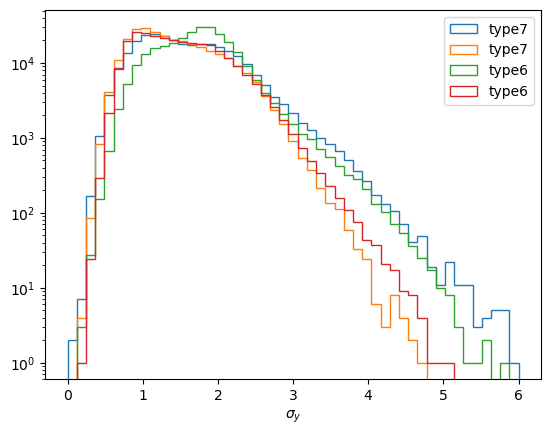

In [25]:
for i, type in enumerate(types): 
    plt.hist(df_s[i]['sigmay']* 18.75,bins=np.linspace(0,6,50), histtype='step', label = type)
plt.xlabel('$\sigma_{y}$')
plt.yscale('log')
plt.legend()
plt.show()

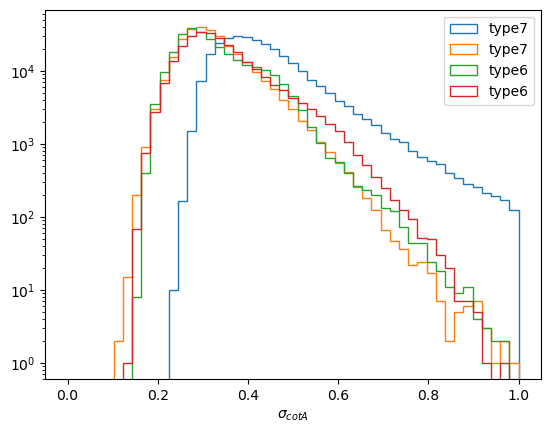

In [26]:
for i, type in enumerate(types): 
    plt.hist(df_s[i]['sigmacotA'] * 8,bins=np.linspace(0,1.0,50), histtype='step', label = type)
plt.xlabel('$\sigma_{cotA}$')
plt.yscale('log')
plt.legend()
plt.show()

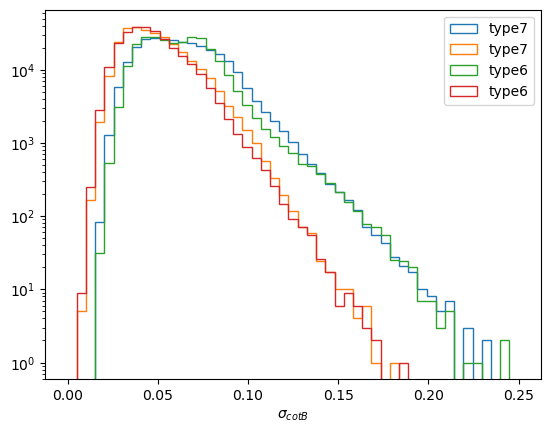

In [27]:
for i, type in enumerate(types): 
    plt.hist(df_s[i]['sigmacotB'] * 0.5 ,bins=np.linspace(0,0.25,50), histtype='step', label = type)
plt.xlabel('$\sigma_{cotB}$')
plt.yscale('log')
plt.legend()
plt.show()

In [28]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def pull_plot(ax, var, i, name, type):
    h = ax.hist(df_s[i][var],bins=np.linspace(-5,5,50),histtype='step')
    ax.set_xlabel(name)
    ax.set_yscale('log')
    ax.set_ylim(0.5,100000)


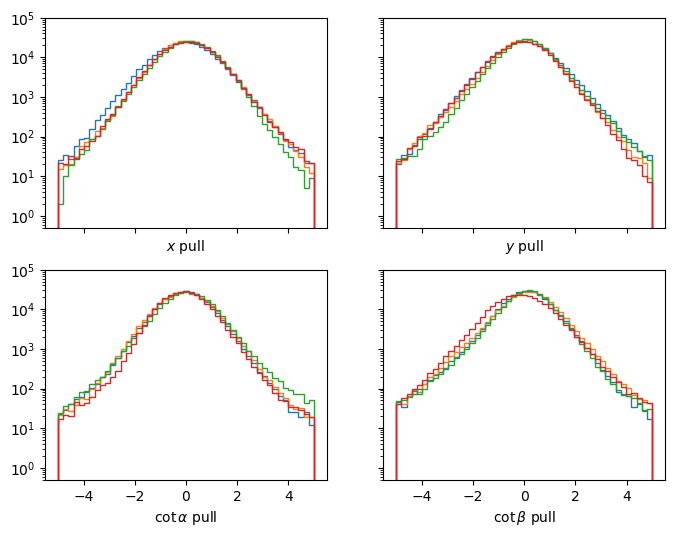

In [29]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
for i, type in enumerate(types): 
    pull_plot(axes[0][0],'pullx',i, r'$x$ pull', type)
    pull_plot(axes[0][1],'pully',i, r'$y$ pull', type)
    pull_plot(axes[1][0],'pullcotA',i, r'$\cot\alpha$ pull', type)
    pull_plot(axes[1][1],'pullcotB',i, r'$\cot\beta$ pull', type)

save_fig_path = os.path.join(base_dir, 'Pull.png')
plt.savefig(save_fig_path)

plt.show()

In [30]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def pull_plot(ax, var, name):
    
    h = ax.hist(df[var],bins=np.linspace(-5,5,50),histtype='step')
    ax.set_xlabel(name)
    ax.set_yscale('log')

    ydata = h[0]
    xdata = h[1][:-1]+3/50.

    pars, cov = curve_fit(gauss,xdata,ydata)

    xbins = np.linspace(-5,5,100)
    ax.plot(xbins,gauss(xbins,pars[0],pars[1],pars[2]),color='black')
    ax.set_ylim(0.5,100000)

    print('Mean',pars[1])
    print('Sigma',pars[2])
    
    ax.text(-5,2000,"$\mu$="+str(round(pars[1],2)))
    ax.text(-5,1000,"$\sigma$="+str(round(abs(pars[2]),2)))

Mean 0.001990607924092054
Sigma 0.9112554531272542
Mean -0.10007582353776445
Sigma 0.9002707723483853
Mean -0.15151456638701502
Sigma 0.7856373306043918
Mean -0.201198583256049
Sigma 0.9439440358002548


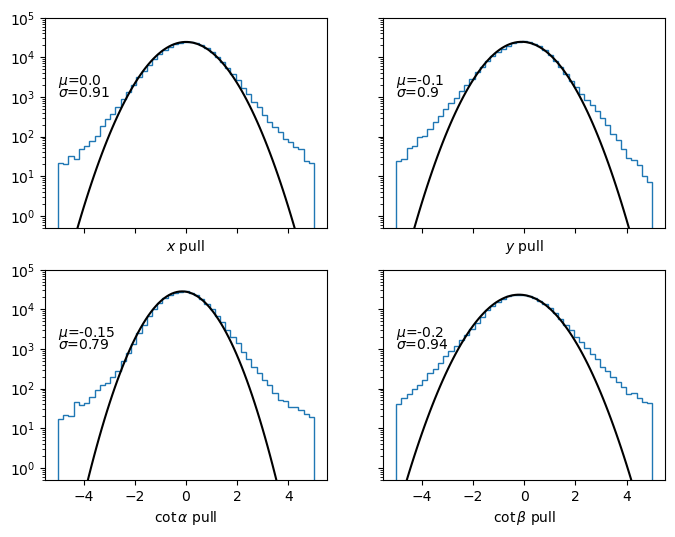

In [31]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
pull_plot(axes[0][0],'pullx',r'$x$ pull')
pull_plot(axes[0][1],'pully',r'$y$ pull')
pull_plot(axes[1][0],'pullcotA',r'$\cot\alpha$ pull')
pull_plot(axes[1][1],'pullcotB',r'$\cot\beta$ pull')

save_fig_path = os.path.join(base_dir, 'Pull.png')
plt.savefig(save_fig_path)

plt.show()

In [32]:
def residual_plot(ax, thisdf, var1, var2, name, scaling=1.0, hatch = '//', linestyle = '-', linewidth = 0.8):
    
    nbins = 15
    
    var1_scaled = thisdf[var1] * scaling
    var2_scaled = thisdf[var2] * scaling
    residual_scaled = var1_scaled - var2_scaled
    
    xmin = np.min(var1_scaled)
    xmax = np.max(var1_scaled)
    
    step = 1.0*(xmax-xmin)/nbins
    
    x = sns.regplot(x=var1_scaled, y=residual_scaled, x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = residual_scaled
    print(var1)
    
    means = []
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
        downbar += [means[i] - np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
    
    fill = ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2, hatch = hatch)
    fill_color = fill.get_facecolor()[0]
    x_points = np.linspace(xmin, xmax, nbins)

    fill.set_edgecolor(fill_color)
    
    ax.plot(x_points, upbar, color=fill_color, linestyle=linestyle, linewidth=linewidth, label='Upper Bound')
    ax.plot(x_points, downbar, color=fill_color, linestyle=linestyle, linewidth=linewidth, label='Lower Bound')

def inverse_cot(cota):
    a = np.arctan(1.0/cota)
    a[np.where(a<0)] = a[np.where(a<0)] + pi
    return a    

def residual_plot_deg(ax, thisdf, var1, var2, name, scaling=1.0, hatch = '//', linestyle = '-', linewidth = 0.8):
    # positions
    if 'cot' not in var1:
        residual_plot(ax, thisdf, var1, var2, name, scaling=scaling)
        return

    thisdf['angle'] = inverse_cot(thisdf[var2].values * scaling)*180/pi
    
    thisdf['angleup'] = abs(inverse_cot((thisdf[var2].values + thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angledown'] = abs(inverse_cot((thisdf[var2].values - thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angletrue'] = inverse_cot(thisdf[var1].values * scaling)*180/pi
        
    var1 = 'angletrue'
    var2 = 'angle'
    
    nbins = 15
    xmin = np.min(thisdf[var1])
    xmax = np.max(thisdf[var1])
    
    step = 1.0*(xmax-xmin)/nbins
        
    x = sns.regplot(x=thisdf[var1], y=(thisdf[var1]-thisdf[var2]), x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = (thisdf[var1]-thisdf[var2])
    print(var1)
    
    means = []    
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['angleup'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        downbar += [means[i] - np.mean(thisdf['angledown'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
    #ax.scatter(x=np.linspace(xmin,xmax,nbins),y=means)
    fill = ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2, hatch = hatch)

    fill_color = fill.get_facecolor()[0]
    x_points = np.linspace(xmin, xmax, nbins)

    fill.set_edgecolor(fill_color)
    
    ax.plot(x_points, upbar, color=fill_color, linestyle=linestyle, linewidth=linewidth, label='Upper Bound')
    ax.plot(x_points, downbar, color=fill_color, linestyle=linestyle, linewidth=linewidth, label='Lower Bound')

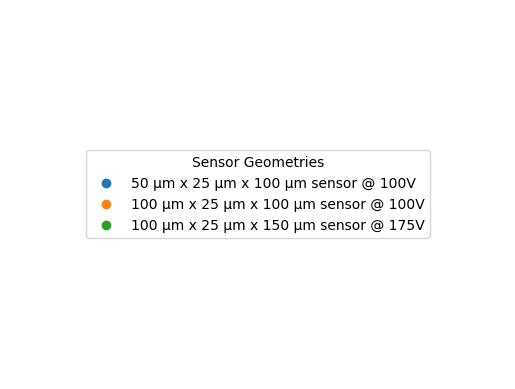

In [33]:
types_info = {
    'type 5': '50 µm x 25 µm x 100 µm sensor @ 100V',
    'type 6': '100 µm x 25 µm x 100 µm sensor @ 100V',
    'type 7': '100 µm x 25 µm x 150 µm sensor @ 175V'
}

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots()
for color, (type_name, label) in zip(default_colors, types_info.items()):
    ax.plot([], [], color=color, label=label, marker='o', linestyle='None')
legend = ax.legend(loc='center', frameon=True, title="Sensor Geometries")
ax.axis('off')  
plt.show()

In [41]:
geometry = ['(100,25,150)um-175V', '(100,25,150)um-175V', '(100,25,100)um-100V', '(100,25,100)um-100V']
hatches = ['//', '|', '-', '\\\\']
linestyles = ['-', '--', '-.', ':']
linewidth = 2.0

xtrue
ytrue


/tmp/ipykernel_3446926/3159802458.py:39: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue
angletrue
xtrue
ytrue
angletrue
angletrue


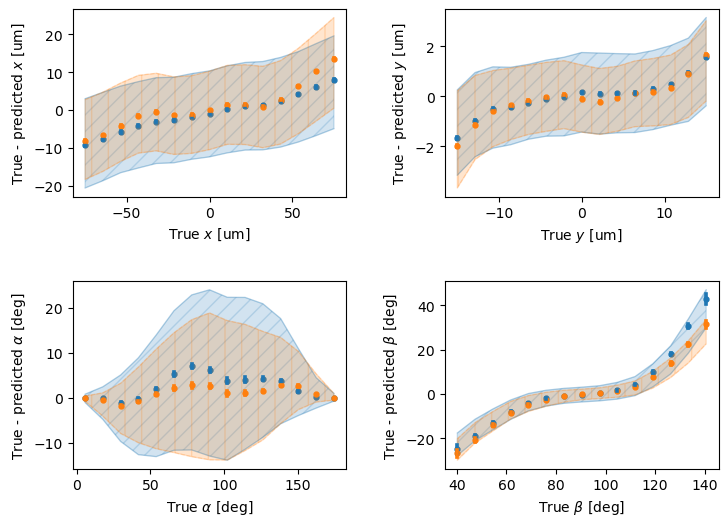

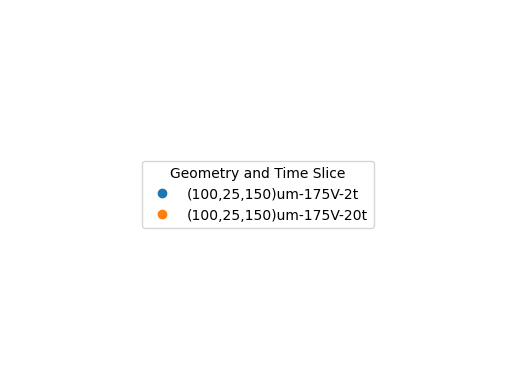

In [42]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)


labels = []
for i, type in enumerate(types): 
    if i == 0 or i == 1:
        label = f'{geometry[i]}-{time_sl[i]}t'
        labels.append(label)
        residual_plot(axes[0][0],df_s[i],'xtrue','x',r'$x$ [um]', scaling=75.0, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot(axes[0][1],df_s[i],'ytrue','y',r'$y$ [um]', scaling=18.75, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot_deg(axes[1][0],df_s[i],'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot_deg(axes[1][1],df_s[i],'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5, hatch = hatches[i], linestyle = linestyles[i])

    

save_fig_path = os.path.join(base_dir, 'summary.png')
plt.savefig(save_fig_path)


default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots()
for color, label in zip(default_colors, labels):
    ax.plot([], [], color=color, label=label, marker='o', linestyle='None') 
legend = ax.legend(loc='center', frameon=True, title="Geometry and Time Slice")
ax.axis('off') 
plt.show()

xtrue
ytrue


/tmp/ipykernel_3446926/3159802458.py:39: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


/tmp/ipykernel_3446926/3159802458.py:39: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue
xtrue
ytrue


/tmp/ipykernel_3446926/3159802458.py:39: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


/tmp/ipykernel_3446926/3159802458.py:39: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


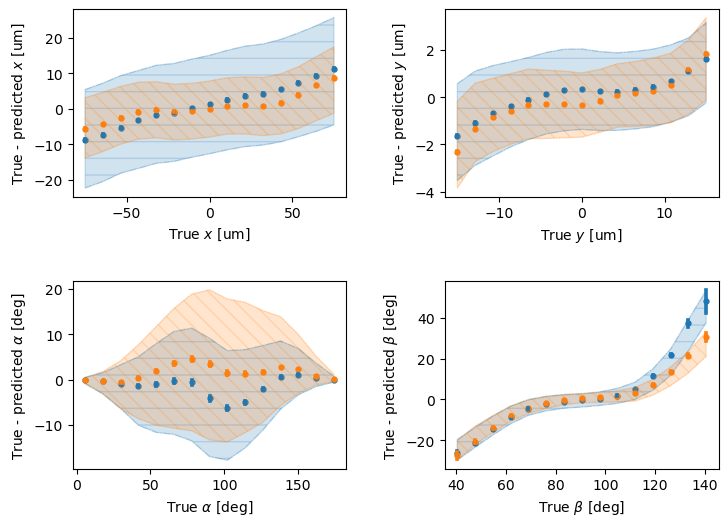

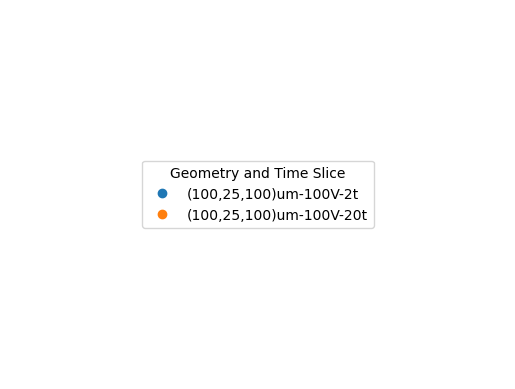

In [43]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)


labels = []
for i, type in enumerate(types): 
    if i == 2 or i == 3:
        label = f'{geometry[i]}-{time_sl[i]}t'
        labels.append(label)
        residual_plot(axes[0][0],df_s[i],'xtrue','x',r'$x$ [um]', scaling=75.0, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot(axes[0][1],df_s[i],'ytrue','y',r'$y$ [um]', scaling=18.75, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot_deg(axes[1][0],df_s[i],'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot_deg(axes[1][1],df_s[i],'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5, hatch = hatches[i], linestyle = linestyles[i])

    

save_fig_path = os.path.join(base_dir, 'summary.png')
plt.savefig(save_fig_path)


default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots()
for color, label in zip(default_colors, labels):
    ax.plot([], [], color=color, label=label, marker='o', linestyle='None') 
legend = ax.legend(loc='center', frameon=True, title="Geometry and Time Slice")
ax.axis('off') 
plt.show()

xtrue
ytrue


/tmp/ipykernel_3446926/3159802458.py:39: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue
angletrue
xtrue
ytrue
angletrue
angletrue


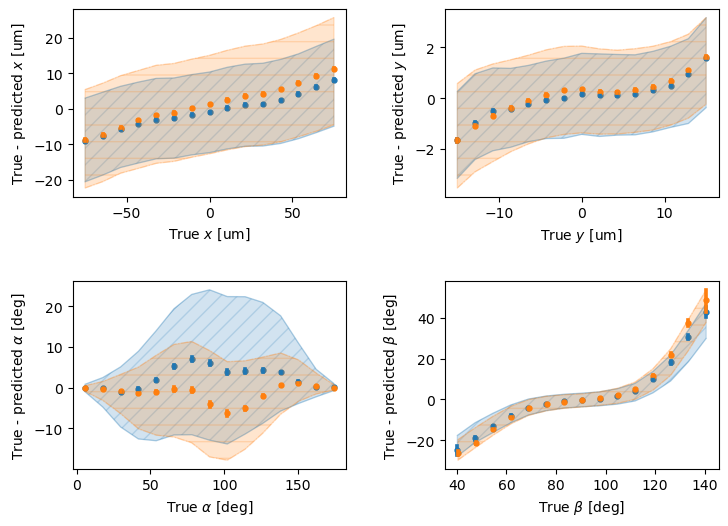

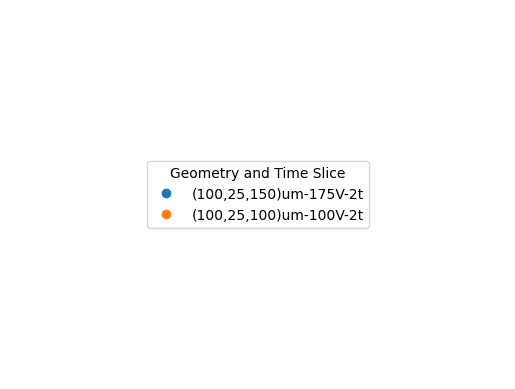

In [44]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)

labels = []
for i, type in enumerate(types): 
    if i == 0 or i == 2:
        label = f'{geometry[i]}-{time_sl[i]}t'
        labels.append(label)
        residual_plot(axes[0][0],df_s[i],'xtrue','x',r'$x$ [um]', scaling=75.0, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot(axes[0][1],df_s[i],'ytrue','y',r'$y$ [um]', scaling=18.75, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot_deg(axes[1][0],df_s[i],'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot_deg(axes[1][1],df_s[i],'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5, hatch = hatches[i], linestyle = linestyles[i])

    

save_fig_path = os.path.join(base_dir, 'summary.png')
plt.savefig(save_fig_path)


default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots()
for color, label in zip(default_colors, labels):
    ax.plot([], [], color=color, label=label, marker='o', linestyle='None') 
legend = ax.legend(loc='center', frameon=True, title="Geometry and Time Slice")
ax.axis('off') 
plt.show()

xtrue
ytrue


/tmp/ipykernel_3446926/3159802458.py:39: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue
angletrue
xtrue
ytrue
angletrue
angletrue


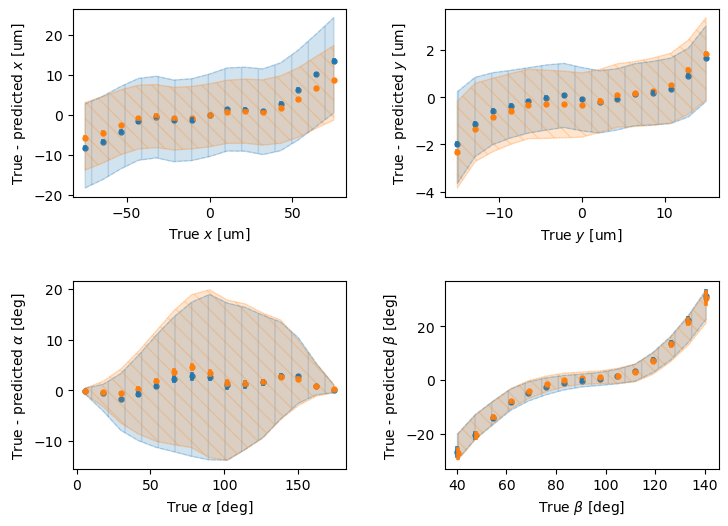

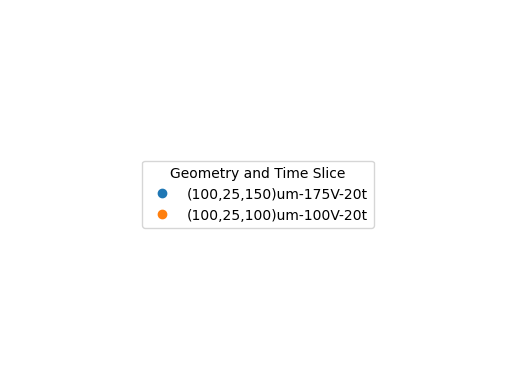

In [45]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)


labels = []
for i, type in enumerate(types): 
    if i == 1 or i == 3:
        label = f'{geometry[i]}-{time_sl[i]}t'
        labels.append(label)
        residual_plot(axes[0][0],df_s[i],'xtrue','x',r'$x$ [um]', scaling=75.0, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot(axes[0][1],df_s[i],'ytrue','y',r'$y$ [um]', scaling=18.75, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot_deg(axes[1][0],df_s[i],'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0, hatch = hatches[i], linestyle = linestyles[i])
        residual_plot_deg(axes[1][1],df_s[i],'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5, hatch = hatches[i], linestyle = linestyles[i])

    

save_fig_path = os.path.join(base_dir, 'summary.png')
plt.savefig(save_fig_path)


default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots()
for color, label in zip(default_colors, labels):
    ax.plot([], [], color=color, label=label, marker='o', linestyle='None') 
legend = ax.legend(loc='center', frameon=True, title="Geometry and Time Slice")
ax.axis('off') 
plt.show()

In [46]:
for i, type in enumerate(types): 
    print(f'{types[i]}:',sensor_geometries[f'{dataset_name} {type}'])

type7: 100 um x 25 um x 150 um sensor @ 175V
type7: 100 um x 25 um x 150 um sensor @ 175V
type6: 100 um x 25 um x 100 um sensor @ 100V
type6: 100 um x 25 um x 100 um sensor @ 100V
